In [15]:
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [16]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [17]:
from scipy.optimize import minimize as sci_min
def minimize(loss_fn, grad_loss_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize loss_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return loss_fn(theta, X, y)
    def gradient(theta):
        return grad_loss_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress and iters % progress == 0:
            print(f'theta: {theta} | loss: {loss_fn(theta, X, y):.2f}')
        iters += 1
        
    print_theta(theta)
    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

# Multiple Linear Regression

Our simple linear model has a key advantage over the constant model: it uses the data when making predictions. However, it is still rather limited since simple linear models only use one variable in our dataset. Many datasets have many potentially useful variables, and multiple linear regression can take advantage of that. For example, consider the following dataset on car models and their milage per gallon (MPG):

In [18]:
mpg = pd.read_csv('mpg.csv').dropna().reset_index(drop=True)
mpg

,mpg,cylinders,displacement,horsepower,...,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,...,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,...,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,...,11.0,70,1,plymouth satellite
...,...,...,...,...,...,...,...,...,...
389,32.0,4,135.0,84.0,...,11.6,82,1,dodge rampage
390,28.0,4,120.0,79.0,...,18.6,82,1,ford ranger
391,31.0,4,119.0,82.0,...,19.4,82,1,chevy s-10


It seems likely that multiple attributes of a car model will affect its MPG. For example, the MPG seems to decrease as horsepower increases:

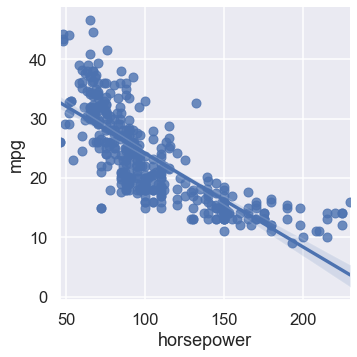

In [19]:
sns.lmplot(x='horsepower', y='mpg', data=mpg);

However, cars released later generally have better MPG than older cars:

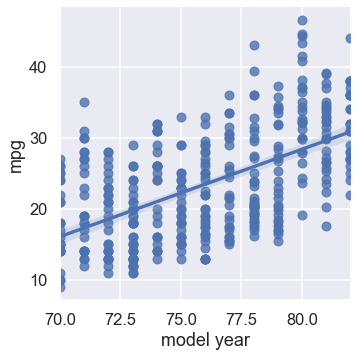

In [20]:
sns.lmplot(x='model year', y='mpg', data=mpg);

It seems possible that we can get a more accurate model if we could take both horsepower and model year into account when making predictions about the MPG. In fact, perhaps the best model takes into account all the numerical variables in our dataset. We can extend our univariate linear regression to allow prediction based on any number of attributes.

We state the following model:

$$
f_\boldsymbol\theta (\textbf{x}) = \theta_0 + \theta_1 x_1 + \ldots + \theta_p x_p
$$

Where $ \textbf{x} $ now represents a vector containing $ p $ attributes of a single car. The model above says, "Take multiple attributes of a car, multiply them by some weights, and add them together to make a prediction for MPG."


For example, if we're making a prediction on the first car in our dataset using the horsepower, weight, and model year columns, the vector $ \textbf{x} $ looks like:

In [21]:
mpg.loc[0:0, ['horsepower', 'weight', 'model year']]

,horsepower,weight,model year
0,130.0,3504.0,70


In there examples, we've kept the column names for clarity but keep in mind that $ \textbf{x} $ only contains the numerical values of the table above: $ \textbf{x} = [130.0, 3504.0, 70] $.

Now, we will perform a notational trick that will greatly simplify later formulas. We will prepend the value $ 1 $ to the vector $ \textbf{x} $, so that we have the following vector for $ \textbf{x} $:

In [22]:
mpg_mat = mpg.assign(bias=1)
mpg_mat.loc[0:0, ['bias', 'horsepower', 'weight', 'model year']]

,bias,horsepower,weight,model year
0,1,130.0,3504.0,70


Now, observe what happens to the formula for our model:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x})
&= \theta_0 + \theta_1 x_1 + \ldots + \theta_p x_p \\
&= \theta_0 (1) + \theta_1 x_1 + \ldots + \theta_p x_p \\
&= \theta_0 x_0 + \theta_1 x_1 + \ldots + \theta_p x_p \\
f_\boldsymbol\theta (\textbf{x}) &= \boldsymbol\theta \cdot \textbf{x}
\end{aligned}
$$

Where $ \boldsymbol\theta \cdot \textbf{x} $ is the vector dot product of $ \boldsymbol\theta $ and $ \textbf{x} $. Vector and matrix notation were designed to succinctly write linear combinations and is thus well-suited for our linear models. However, you will have to remember from now on that $ \boldsymbol\theta \cdot \textbf{x} $ is a vector-vector dot product. When in doubt, you can always expand the dot product into simple multiplications and additions.

Now, we define the matrix $  \textbf{X} $ as the matrix containing every car model as a row and a first column of biases. For example, here are the first five rows of $  \textbf{X} $:

In [23]:
mpg_mat = mpg.assign(bias=1)
mpg_mat.loc[0:4, ['bias', 'horsepower', 'weight', 'model year']]

,bias,horsepower,weight,model year
0,1,130.0,3504.0,70
1,1,165.0,3693.0,70
2,1,150.0,3436.0,70
3,1,150.0,3433.0,70
4,1,140.0,3449.0,70


Again, keep in mind that the actual matrix $  \textbf{X} $ only contains the numerical values of the table above.

Notice that $ \textbf{X} $ is composed of multiple $ \textbf{x} $ vectors stacked on top of each other. To keep the notation clear, we define $ \textbf{X}_{i} $ to refer to the row vector with index $ i $ of $  \textbf{X} $. We define $ X_{i,j} $ to refer to the element with index $ j $ of the row with index $ i $ of $  \textbf{X} $. Thus, $ \textbf{X}_i $ is a $ p $-dimensional vector and $ X_{i,j} $ is a scalar. $  \textbf{X} $ is an $ n \times p $ matrix, where $n$ is the number of car examples we have and $p$ is the number of attributes we have for a single car.

For example, from the table above we have $ \textbf{X}_4 = [1, 140, 3449, 70] $ and $ X_{4,1} = 140 $. This notation becomes important when we define the loss function since we will need both $  \textbf{X} $, the matrix of input values, and $ \textbf{y} $, the vector of MPGs.

## MSE Loss and its Gradient

The mean squared error loss function takes in a vector of weights $ \boldsymbol\theta $, a matrix of inputs $  \textbf{X} $, and a vector of observed MPGs $ \textbf{y} $:

$$
\begin{aligned}
L(\boldsymbol\theta, \textbf{X}, \textbf{y})
&= \frac{1}{n} \sum_{i}(y_i - f_\boldsymbol\theta (\textbf{X}_i))^2\\
\end{aligned}
$$

We've previously derived the gradient of the MSE loss with respect to $ \boldsymbol\theta $:

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{X}, \textbf{y})
&= -\frac{2}{n} \sum_{i}(y_i - f_\boldsymbol\theta (\textbf{X}_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{X}_i))\\
\end{aligned}
$$

We know that:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x}) &= \boldsymbol\theta \cdot \textbf{x} \\
\end{aligned}
$$

Let's now compute $ \nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{x}) $. The result is surprisingly simple because $ \boldsymbol\theta \cdot \textbf{x} = \theta_0 x_0 + \ldots + \theta_p x_p $ and thus $ \frac{\partial}{\partial \theta_0}(\boldsymbol\theta \cdot \textbf{x}) = x_0 $, $ \frac{\partial}{\partial \theta_1}(\boldsymbol\theta \cdot \textbf{x}) = x_1 $, and so on.

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{x})
&= \nabla_{\boldsymbol\theta} [ \boldsymbol\theta \cdot \textbf{x} ] \\
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} (\boldsymbol\theta \cdot \textbf{x}) \\
     \frac{\partial}{\partial \theta_1} (\boldsymbol\theta \cdot \textbf{x}) \\
     \vdots \\
     \frac{\partial}{\partial \theta_p} (\boldsymbol\theta \cdot \textbf{x}) \\
   \end{bmatrix} \\
&= \begin{bmatrix}
     x_0 \\
     x_1 \\
     \vdots \\
     x_p
   \end{bmatrix} \\
\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{x}) &= \textbf{x}
\end{aligned}
$$

Finally, we plug this result back into our gradient calculations:

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{X}, \textbf{y})
&= -\frac{2}{n} \sum_{i}(y_i - f_\boldsymbol\theta (\textbf{X}_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (\textbf{X}_i))\\
&= -\frac{2}{n} \sum_{i}(y_i - \boldsymbol\theta \cdot \textbf{X}_i)(\textbf{X}_i)\\
\end{aligned}
$$

Remember that since $ y_i - \boldsymbol\theta \cdot \textbf{X}_i $ is a scalar and $ \textbf{X}_i $ is a $ p $-dimensional vector, the gradient $ \nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{X}, \textbf{y}) $ is a $ p $-dimensional vector.

We saw this same type of result when we computed the gradient for univariate linear regression and found that it was 2-dimensional since $ \boldsymbol\theta $ was 2-dimensional.

## Fitting the Model With Gradient Descent

We can now plug in our loss and its derivative into gradient descent. As usual, we will define the model, loss, and gradient loss in Python.

In [24]:
def linear_model(thetas, X):
    '''Returns predictions by a linear model on x_vals.'''
    return X @ thetas

def mse_loss(thetas, X, y):
    return np.mean((y - linear_model(thetas, X)) ** 2)

def grad_mse_loss(thetas, X, y):
    n = len(X)
    return -2 / n * (X.T @ y  - X.T @ X @ thetas)

In [27]:
thetas = np.array([1, 1, 1, 1])
X = np.array([[2, 1, 0, 1], [1, 2, 3, 4]])
y = np.array([3, 9])
assert np.allclose(linear_model(thetas, X), [4, 10])
assert np.allclose(mse_loss(thetas, X, y), 1.0)
assert np.allclose(grad_mse_loss(thetas, X, y), [ 3.,  3.,  3.,  5.])
assert np.allclose(grad_mse_loss(thetas, X + 1, y), [ 25.,  25.,  25.,  35.])

Now, we can simply plug in our functions into our gradient descent minimizer:

In [32]:
X = (mpg_mat
     .loc[:, ['bias', 'horsepower', 'weight', 'model year']]
     .values)
y = mpg_mat['mpg'].values

In [34]:
%%time 

thetas = minimize(mse_loss, grad_mse_loss, X, y)
print(f'theta: {thetas} | loss: {mse_loss(thetas, X, y):.2f}')

theta: [0. 0. 0. 0.] | loss: 610.47
theta: [0.   0.   0.01 0.  ] | loss: 178.95
theta: [ 0.01 -0.11 -0.    0.55] | loss: 15.78
theta: [ 0.01 -0.01 -0.01  0.58] | loss: 11.97
theta: [-4.   -0.01 -0.01  0.63] | loss: 11.81
theta: [-13.72  -0.    -0.01   0.75] | loss: 11.65
theta: [-13.72  -0.    -0.01   0.75] | loss: 11.65
CPU times: user 5.21 ms, sys: 2.23 ms, total: 7.44 ms
Wall time: 5.41 ms


According to gradient descent, our linear model is:

$y = -13.72 - 0.01x_2 + 0.75x_3$


## Visualizing our Predictions

How does our model do? We can see that the loss decreased dramatically (from 610 to 11.6). We can show the predictions of our model alongside the original values:

In [35]:
reordered = ['predicted_mpg', 'mpg', 'horsepower', 'weight', 'model year']
with_predictions = (
    mpg
    .assign(predicted_mpg=linear_model(thetas, X))
    .loc[:, reordered]
)
with_predictions

,predicted_mpg,mpg,horsepower,weight,model year
0,15.45,18.0,130.0,3504.0,70
1,14.05,15.0,165.0,3693.0,70
2,15.79,18.0,150.0,3436.0,70
...,...,...,...,...,...
389,32.46,32.0,84.0,2295.0,82
390,30.35,28.0,79.0,2625.0,82
391,29.73,31.0,82.0,2720.0,82


Since we found $ \boldsymbol\theta $ from gradient descent, we can verify for the first row of our data that $ \boldsymbol\theta \cdot \textbf{X}_0 $ matches our prediction above:

In [36]:
print(f'Prediction for first row: '
      f'{thetas[0] + thetas[1] * 130 + thetas[2] * 3504 + thetas[3] * 70:.2f}')

Prediction for first row: 15.45


We can also plot the residuals of our predictions (actual values - predicted values):

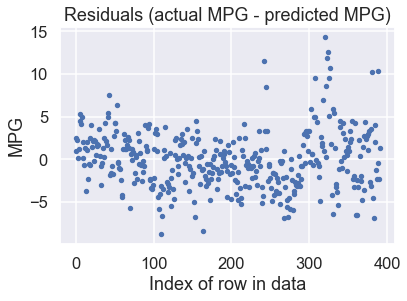

In [38]:
resid = y - linear_model(thetas, X)
plt.scatter(np.arange(len(resid)), resid, s=15)
plt.title('Residuals (actual MPG - predicted MPG)')
plt.xlabel('Index of row in data')
plt.ylabel('MPG');

It looks like our model makes reasonable predictions for many car models, although there are some predictions that were off by over 10 MPG (some cars had under 10 MPG!). Perhaps we are more interested in the percent error between the predicted MPG values and the actual MPG values:

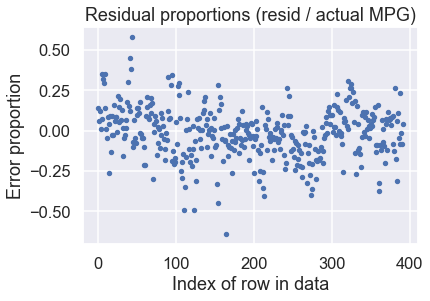

In [39]:
resid_prop = resid / with_predictions['mpg']
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.title('Residual proportions (resid / actual MPG)')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

It looks like our model's predictions are usually within 20% away from the actual MPG values.

## Using All the Data

Notice that in our example thus far, our $  \textbf{X} $ matrix has four columns: one column of all ones, the horsepower, the weight, and the model year. However, model allows us to handle an arbitrary number of columns:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x}) &= \boldsymbol\theta \cdot \textbf{x}
\end{aligned}
$$

As we include more columns into our data matrix, we extend $ \boldsymbol\theta $ so that it has one parameter for each column in $  \textbf{X} $. Instead of only selecting three numerical columns for prediction, why not use all seven of them?

In [43]:
cols = ['bias', 'cylinders', 'displacement', 'horsepower',
        'weight', 'acceleration', 'model year', 'origin']
X = mpg_mat[cols].values
mpg_mat[cols]

,bias,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,1,8,307.0,130.0,3504.0,12.0,70,1
1,1,8,350.0,165.0,3693.0,11.5,70,1
2,1,8,318.0,150.0,3436.0,11.0,70,1
...,...,...,...,...,...,...,...,...
389,1,4,135.0,84.0,2295.0,11.6,82,1
390,1,4,120.0,79.0,2625.0,18.6,82,1
391,1,4,119.0,82.0,2720.0,19.4,82,1


In [44]:
%%time 

thetas_all = minimize(mse_loss, grad_mse_loss, X, y, progress=10)
print(f'theta: {thetas_all} | loss: {mse_loss(thetas_all, X, y):.2f}')

theta: [0. 0. 0. 0. 0. 0. 0. 0.] | loss: 610.47
theta: [-0.5  -0.81  0.02 -0.04 -0.01 -0.07  0.59  1.3 ] | loss: 11.22
theta: [-17.23  -0.49   0.02  -0.02  -0.01   0.08   0.75   1.43] | loss: 10.85
theta: [-17.22  -0.49   0.02  -0.02  -0.01   0.08   0.75   1.43] | loss: 10.85
CPU times: user 5.65 ms, sys: 1.78 ms, total: 7.44 ms
Wall time: 6.42 ms


According to gradient descent, our linear model is:

$y = -17.22 - 0.49x_1 + 0.02x_2 - 0.02x_3 - 0.01x_4 + 0.08x_5 + 0.75x_6 + 1.43x_7$

We see that our loss has decreased from 11.6 with three columns of our dataset to 10.85 when using all seven numerical columns of our dataset. We display the proportion error plots for both old and new predictions below:

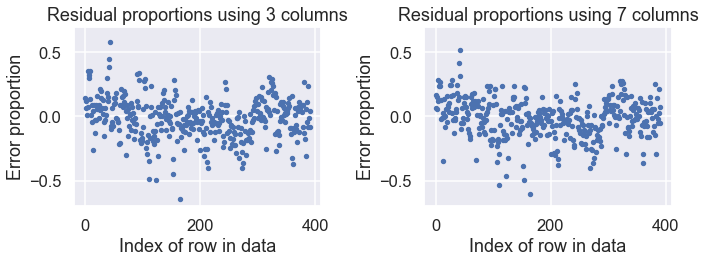

In [45]:
resid_prop_all = (y - linear_model(thetas_all, X)) / with_predictions['mpg']
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.title('Residual proportions using 3 columns')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion')
plt.ylim(-0.7, 0.7)

plt.subplot(122)
plt.scatter(np.arange(len(resid_prop_all)), resid_prop_all, s=15)
plt.title('Residual proportions using 7 columns')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion')
plt.ylim(-0.7, 0.7)

plt.tight_layout();

Although the difference is slight, you can see that the errors are a bit lower when using seven columns compared to using three. Both models are much better than using a constant model, as the below plot shows:

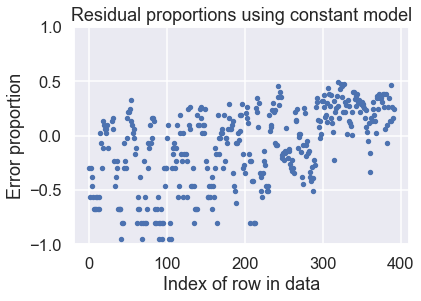

In [46]:
constant_resid_prop = (y - with_predictions['mpg'].mean()) / with_predictions['mpg']
plt.scatter(np.arange(len(constant_resid_prop)), constant_resid_prop, s=15)
plt.title('Residual proportions using constant model')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion')
plt.ylim(-1, 1);

Using a constant model results in over 75% error for many car MPGs!

## Summary

We have introduced the linear model for regression. Unlike the constant model, the linear regression model takes in features of our data into account when making predictions, making it much more useful whenever we have correlations between variables of our data.

The procedure of fitting a model to data should now be quite familiar:

1. Select a model.
1. Select a loss function.
1. Minimize the loss function using gradient descent.

It is useful to know that we can usually tweak one of the components without changing the others. In this section, we introduced the linear model without changing our loss function or using a different minimization algorithm. Although modeling can get complicated, it is usually easier to learn by focusing on one component at a time, then combining different parts together as needed in practice.